# 종합 성능 리포트

[링크](https://github.com/ppabam/101/issues/88)
- 배열 처리에 대한 numpy 함수와 순수 파이썬 라이브러리의 성능 차이 증명
- nGrinder의 결과 데이터를 받아 matplotlib로 그래프 표시
- docker_stats2csv.sh 결과와 통합하여 성능에 미치는 영향 분석

---

## 성능 테스트 절차

### 1. 테스트 환경 파악
   - 테스트/운영환경 (e.g. h/w, s/w, 네트워크 환경 등)
   - 테스트 도구
     
### 2. 요구 되는 성능 기준 파악
    - 응답 시간
    - 시스템 사용률 (e.g. cpu, memory 등)
    
### 3. 테스트 계획 수립
    - 주요 시나리오 정리
    - 테스트 데이터 정의
    - 측정 결과 데이터 정의

### 4. 테스트 환경 설정
    - 테스트 환경/도구 준비 (e.g. nGrinder, JMeter 등)
    - 리소스(서버) 모니터링 환경 준비

### 5. 테스트 구현
    - 테스트 시나리오에 따른 구현 (e.g. nGrinder 스크립트 작성)

### 6. 테스트
    - 테스트 실행 및 모니터링

### 7. 분석 및 리포트
    - 결과/지표 데이터 분석
    - (필요 시) 반복 테스트

---

In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# 공통 함수들

def convert_timestamp_to_datetime(timestamp):
    """
    Unix Timestamp를 받아서 한국 시간대의 datetime 타입으로 변환하는 함수

    :param:
    timestamp: Unix Timestamp

    :return:
    kst_dt: 한국 시간대의 datetime 타입
    """
    utc_dt = datetime.datetime.utcfromtimestamp(timestamp)
    kst_dt = utc_dt + datetime.timedelta(hours=9)
    return kst_dt

def convert_str_to_datetime(dt_str):
    """
    문자열을 '년-월-일 시:분:초' 형태의 datetime 타입응로 변환하는 함수

    :param:
    dt_str: 날짜의 문자열

    :return:
    dt: datetime 타입
    """
    dt = datetime.datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S")
    return dt

def get_dataframe_from_csv(num):
    """
    docker의 상태 정보와 ngrinder 테스트 결과를 담은 csv 파일을 불러와,
    시간대를 맞추고 merge하여 하나의 DataFrame으로 만드는 함수

    :param:
    num: csv파일의 번호

    :return:
    df: merge된 DataFrame
    """
    docker_df = get_docker_stats_df(num).reset_index()
    ngrinder_df = get_ngrinder_stats_df(num).reset_index()

    # 공통된 범위의 최소, 최대 시간을 찾은 후 범위 설정
    min_timestamp = max(docker_df['Timestamp'].min(), ngrinder_df['Timestamp'].min())
    max_timestamp = min(docker_df['Timestamp'].max(), ngrinder_df['Timestamp'].max())

    docker_df = docker_df[(docker_df['Timestamp'] >= min_timestamp) & (docker_df['Timestamp'] <= max_timestamp)]
    ngrinder_df = ngrinder_df[(ngrinder_df['Timestamp'] >= min_timestamp) & (ngrinder_df['Timestamp'] <= max_timestamp)]

    # 두 DataFrame 병합
    df = pd.merge(docker_df, ngrinder_df, on='Timestamp', how='inner')
    
    return df
    
def get_docker_stats_df(num):
    docker_file_path = f"docker_stats/docker_stats_{num}.csv"
    docker_df = pd.read_csv(docker_file_path, usecols=['Timestamp', 'Name', 'CPUPerc', 'MemPerc', 'MemUsage'])
    
    docker_df['Timestamp'] = docker_df['Timestamp'].apply(convert_timestamp_to_datetime)
    docker_df['Name'] = docker_df['Name'].str.split('-').str[1].str.upper()
    docker_df['CPUPerc'] = docker_df['CPUPerc'].str.extract(r'([\d\.]+)').astype(float)
    docker_df['MemPerc'] = docker_df['MemPerc'].str.extract(r'([\d\.]+)').astype(float)
    docker_df['MemUsage'] = docker_df['MemUsage'].str.extract(r'([\d\.]+)').astype(float)
    docker_df.set_index('Timestamp', inplace=True)
    docker_df = docker_df.groupby('Name').resample('10s').mean(numeric_only=True)
    docker_df = docker_df.ffill()
    docker_df = docker_df.bfill()
    
    return docker_df

def get_ngrinder_stats_df(num):
    ngrinder_file_path = f"ngrinder_stats/ngrinder_stats_{num}.csv"
    ngrinder_df = pd.read_csv(ngrinder_file_path, usecols=['DateTime', 'vuser', 'TPS'])

    ngrinder_df = ngrinder_df.rename(columns={'DateTime': 'Timestamp'})
    ngrinder_df['Timestamp'] = ngrinder_df['Timestamp'].apply(convert_str_to_datetime)
    ngrinder_df.set_index('Timestamp', inplace=True)
    ngrinder_df = ngrinder_df.resample('10s').mean(numeric_only=True)
    ngrinder_df = ngrinder_df.ffill()
    ngrinder_df = ngrinder_df.bfill()

    return ngrinder_df

def display_chart(df):
    grouped = df.groupby('Name')
    for name, group in grouped:
        fig, ax1 = plt.subplots(figsize=(10, 5))

        # 첫 번째 서브플롯 (CPU, Memory)
        ax1.plot(group['Timestamp'], group['CPUPerc'], label='CPU Usage (%)', color="red")
        ax1.plot(group['Timestamp'], group['MemPerc'], label='Memory Percentage (%)', color="blue")
        
        # 첫 번째 y축 (CPU 및 Memory Percentage)
        ax1.set_ylabel('CPU & Memory Percentage (%)', color='black')
        ax1.tick_params(axis='y', labelcolor='black')
        ax1.set_ylim(0, 120)

        # 두 번째 y축 (Memory Usage MiB)
        ax2 = ax1.twinx()
        ax2.plot(group['Timestamp'], group['MemUsage'], label='Memory Usage (MiB)', color="green")
        ax2.set_ylabel('Memory Usage (MiB)', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        ax2.set_ylim(0, 220)

        # 첫 번째 서브플롯의 범례 및 격자 추가
        ax1.legend(loc="upper left", bbox_to_anchor=(1.1, 1))
        ax2.legend(loc="upper left", bbox_to_anchor=(1.1, 0.88))
        ax1.grid(True)

        # 타이틀
        plt.title(f'Server Performance Metrics Over Time ({name})')
        plt.xticks(rotation=45)

        # 그래프 출력
        plt.show()

    # 두 번째 서브플롯 (vUsers 및 TPS)
    fig, ax3 = plt.subplots(figsize=(10, 5))
    
    ax3.plot(group['Timestamp'], group['vuser'], label='vUser', color="purple")
    ax3.plot(group['Timestamp'], group['TPS'], label='TPS', color="orange")
    ax3.set_xlabel('Timestamp')
    ax3.set_ylabel('vUser & TPS', color='black')
    ax3.tick_params(axis='y', labelcolor='black')
    ax3.set_ylim(0, group[['vuser', 'TPS']].max().max() * 1.1)

    # 두 번째 서브플롯의 범례 및 격자 추가
    ax3.legend(loc="upper left", bbox_to_anchor=(1.1, 1.05))
    ax3.grid(True)

    # 타이틀
    plt.title("vUser & TPS Trends")
    plt.xticks(rotation=45)

    # 그래프 출력
    plt.show()

# 첫 번째 테스트

- **캐시 서버**
  - CPU: 1.05
  - Memory: 20M
- **api 서버**
  - CPU: 1.0
  - Memory: 100M
- **nGrinder**
  - Vusers: 1,000
  - Ramp-Up Interval: 1,000ms
- **Python**
  - N: 100,000
  - Func: `numpy.randint()` + `np.array + np.array`
- **결과**
  - TPS: 826.5

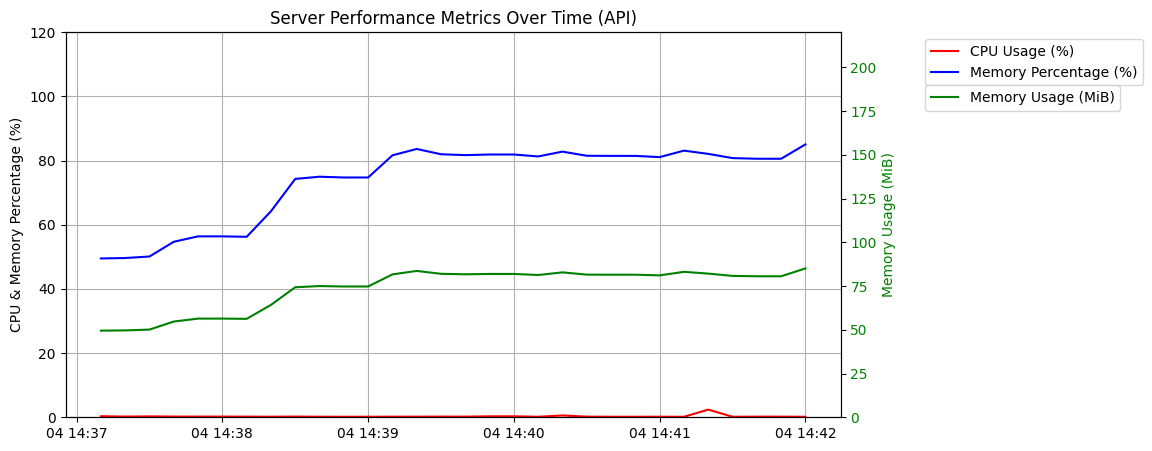

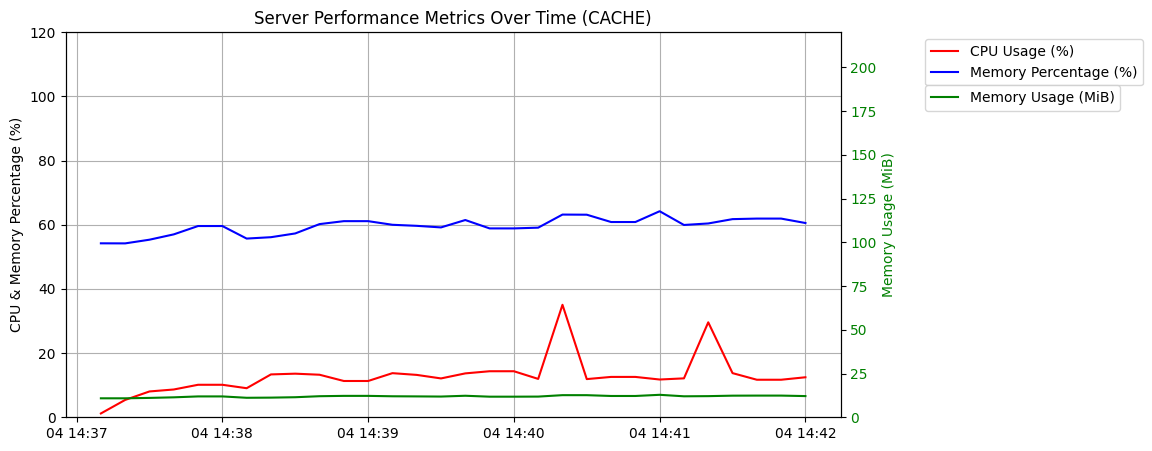

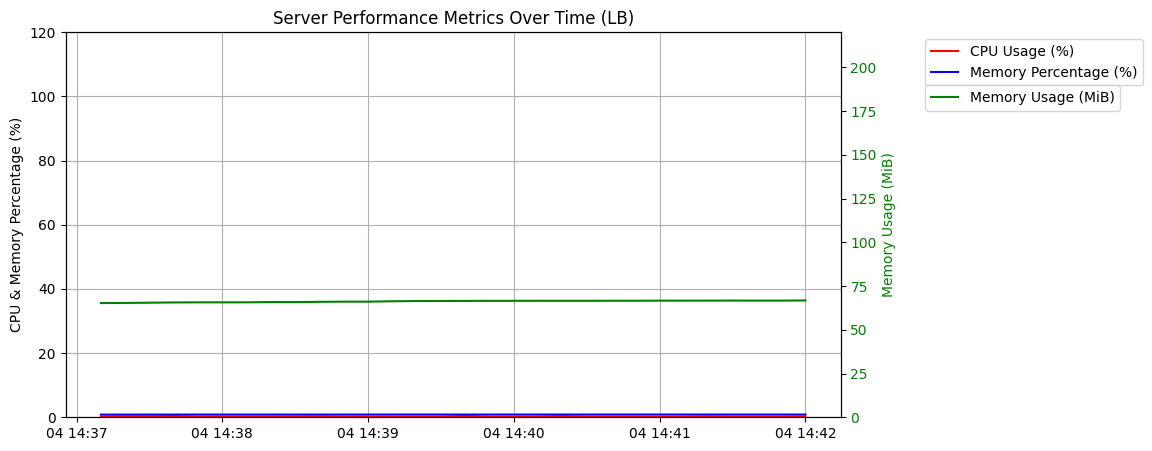

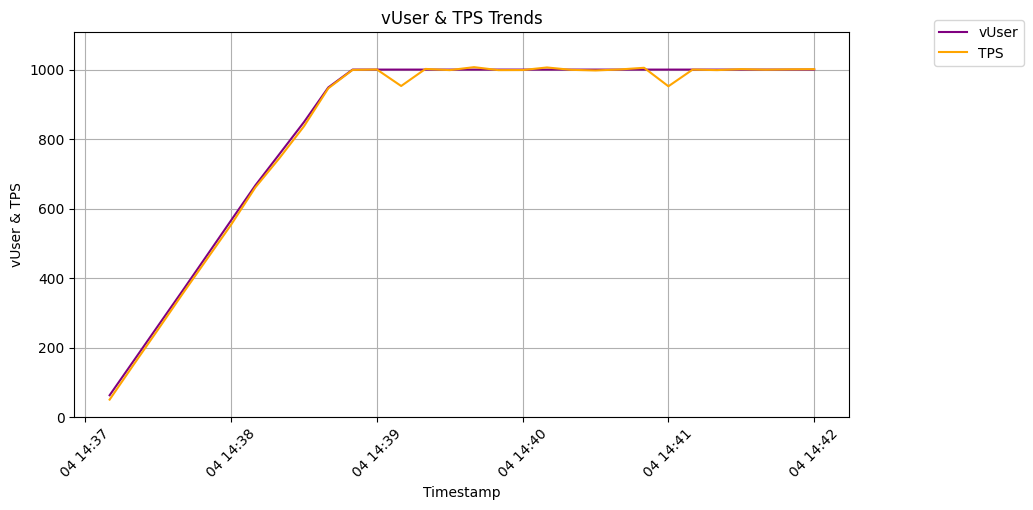

In [2]:
df = get_dataframe_from_csv(1)
display_chart(df)

# 두 번째 테스트

- **캐시 서버**
  - CPU: 1.05
  - Memory: 20M
- **api 서버**
  - CPU: 1.0
  - Memory: 100M
- **nGrinder**
  - Vusers: 1,000
  - Ramp-Up Interval: 1,000ms
- **Python**
  - N: 100,000
  - Func: `random.randint()` + `sum' + 'zip`
- **결과**
  - TPS: 218.5
  - 에러 증가로 인한 테스트 중간 종료

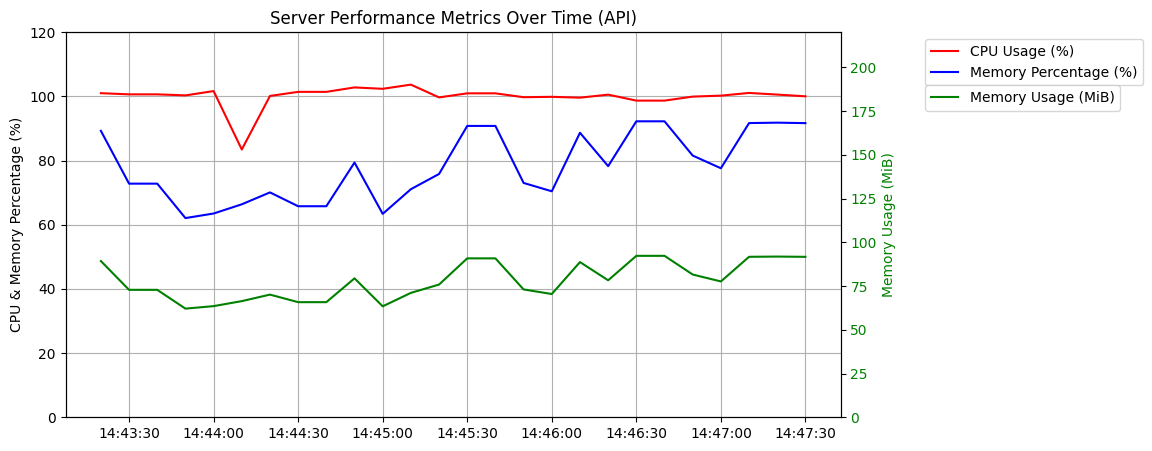

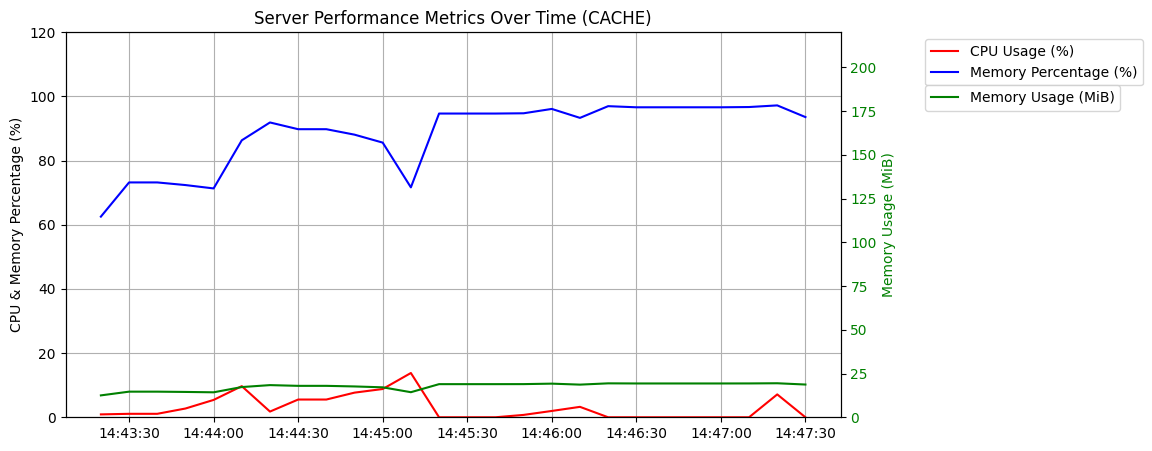

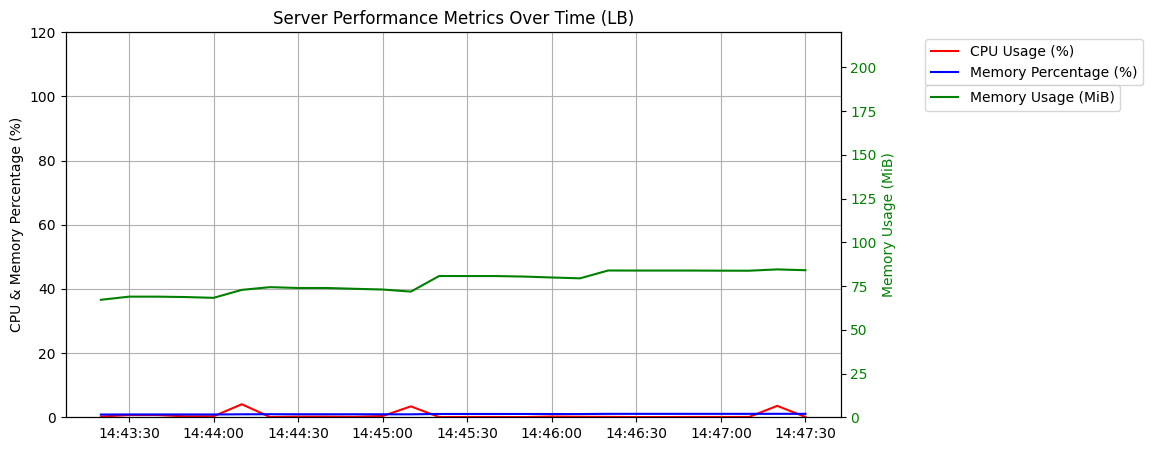

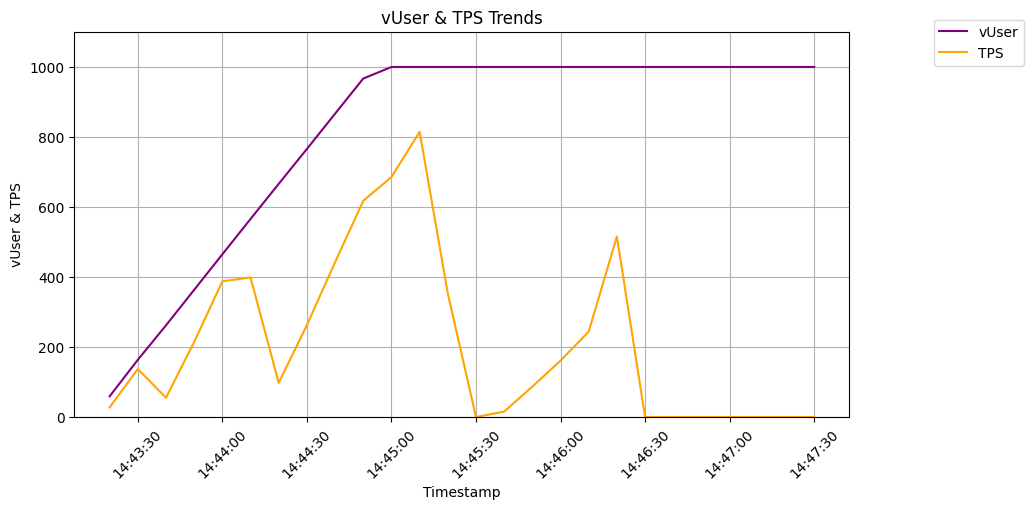

In [3]:
df = get_dataframe_from_csv(2)
display_chart(df)

# 세 번째 테스트

- **캐시 서버**
  - CPU: 1.05
  - Memory: 20M
- **api 서버**
  - CPU: 1.0
  - Memory: 200M
- **nGrinder**
  - Vusers: 1,000
  - Ramp-Up Interval: 1,000ms
- **Python**
  - N: 100,000
  - Func: `numpy.randint()` + `np.array + np.array`
- **결과**
  - TPS: 827.5

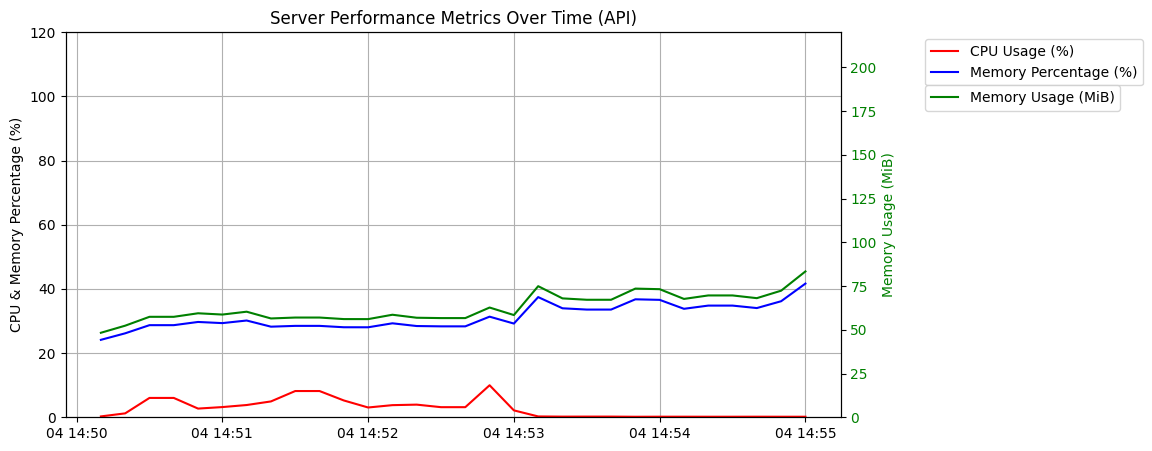

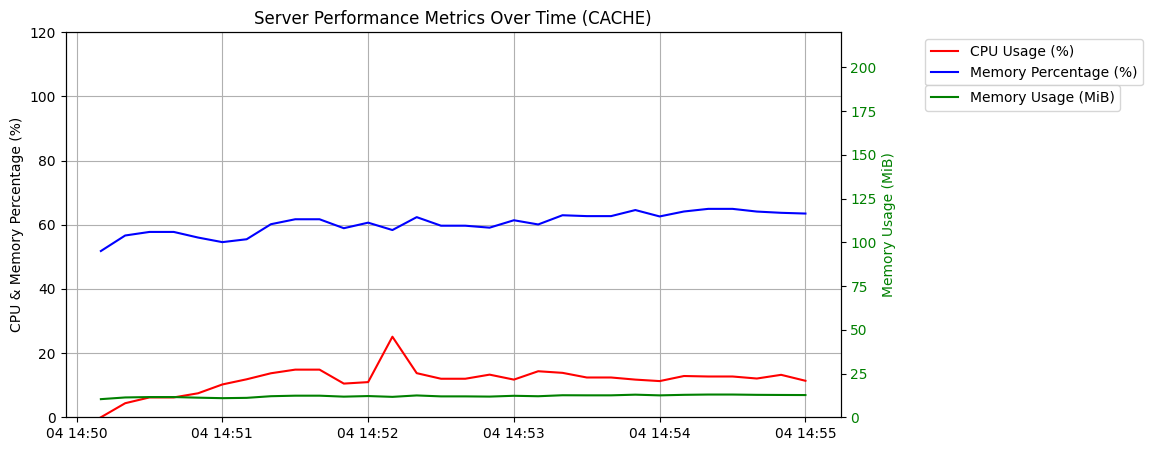

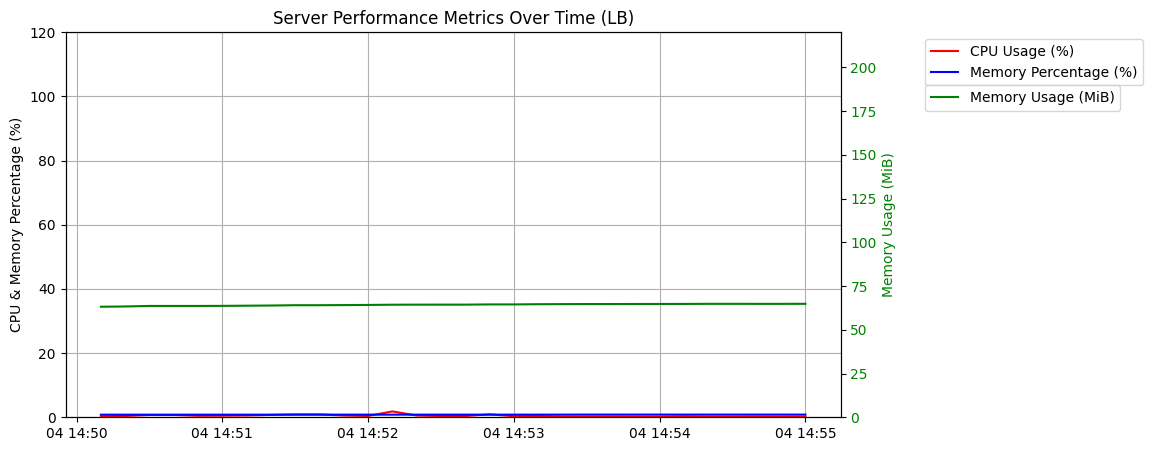

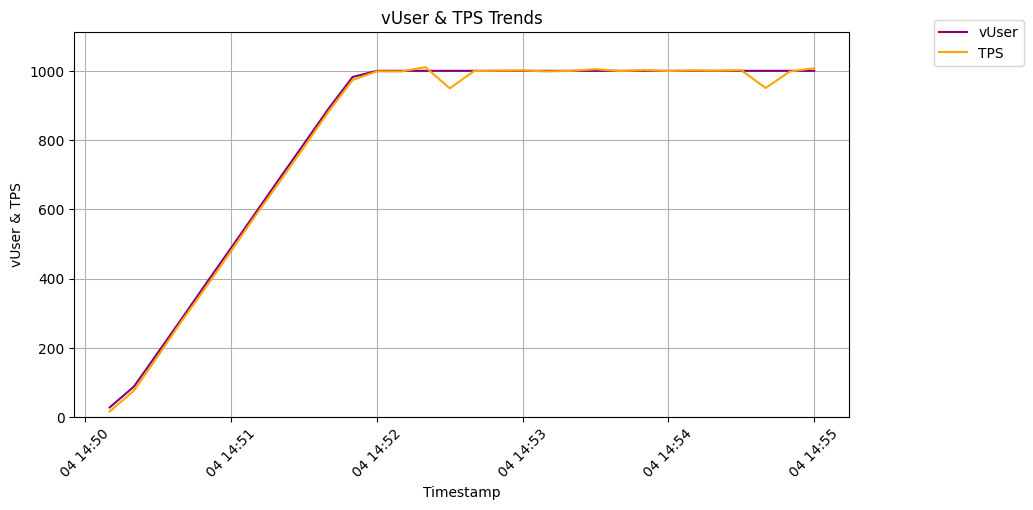

In [4]:
df = get_dataframe_from_csv(3)
display_chart(df)

# 네 번째 테스트

- **캐시 서버**
  - CPU: 1.05
  - Memory: 20M
- **api 서버**
  - CPU: 1.0
  - Memory: 200M
- **nGrinder**
  - Vusers: 1,000
  - Ramp-Up Interval: 1,000ms
- **Python**
  - N: 100,000
  - Func: `random.randint()` + `sum' + 'zip`
- **결과**
  - TPS: 252.8

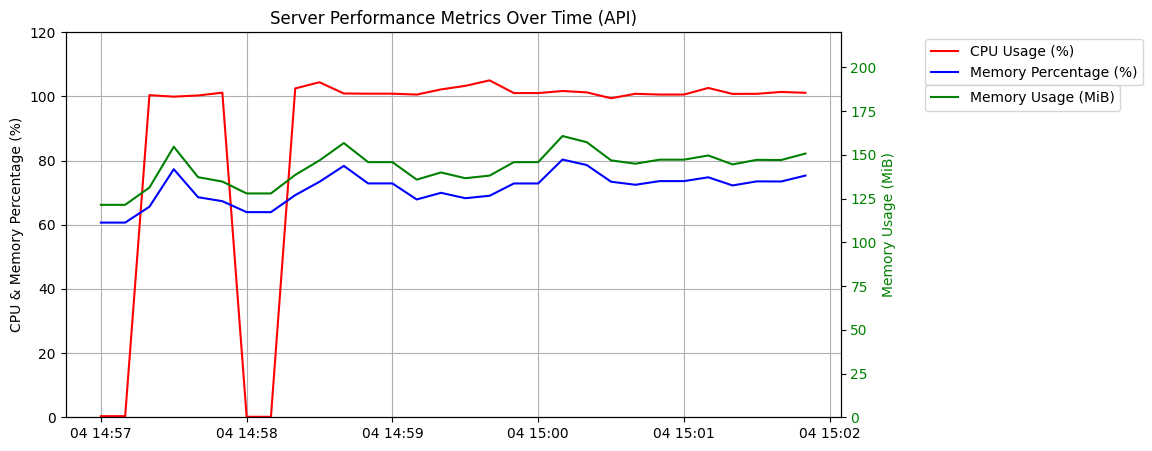

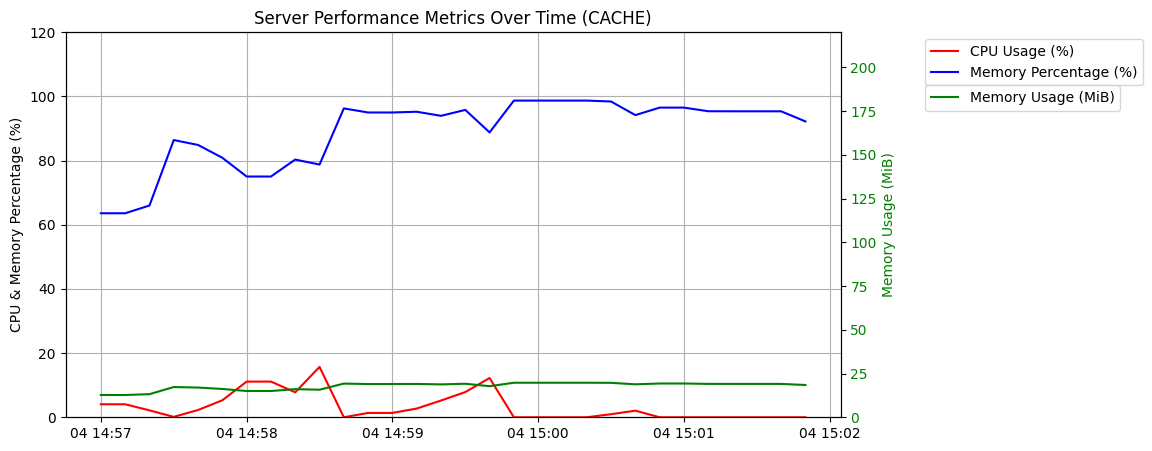

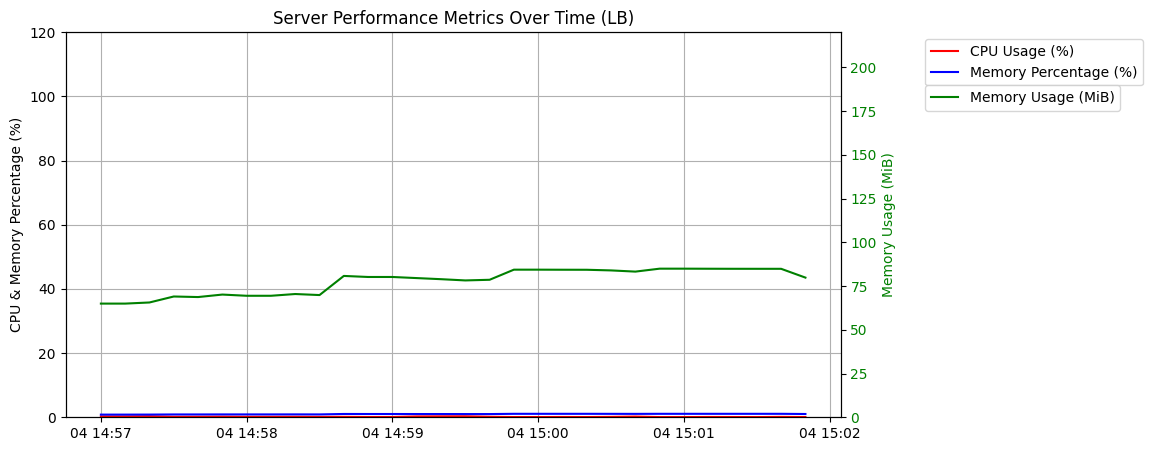

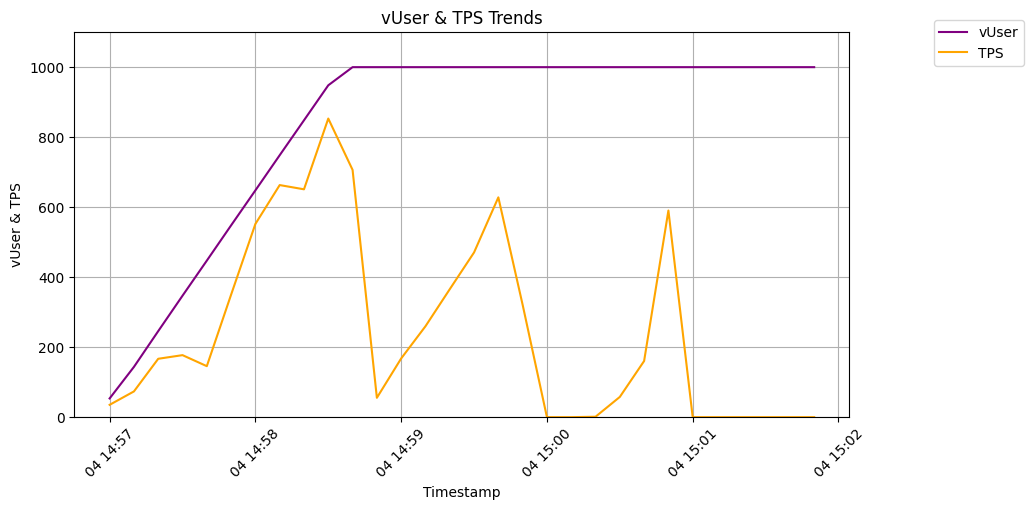

In [5]:
df = get_dataframe_from_csv(4)
display_chart(df)

# 다섯 번째 테스트

- **캐시 서버**
  - CPU: 1.05
  - Memory: 20M
- **api 서버**
  - CPU: 2.0
  - Memory: 100M
- **nGrinder**
  - Vusers: 1,000
  - Ramp-Up Interval: 1,000ms
- **Python**
  - N: 100,000
  - Func: `numpy.randint()` + `np.array + np.array`
- **결과**
  - TPS: 827.6

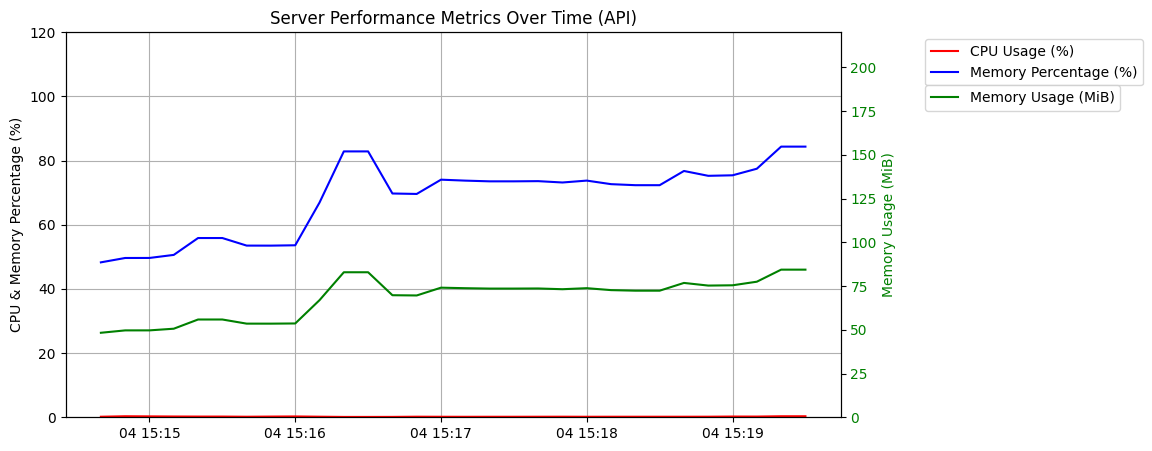

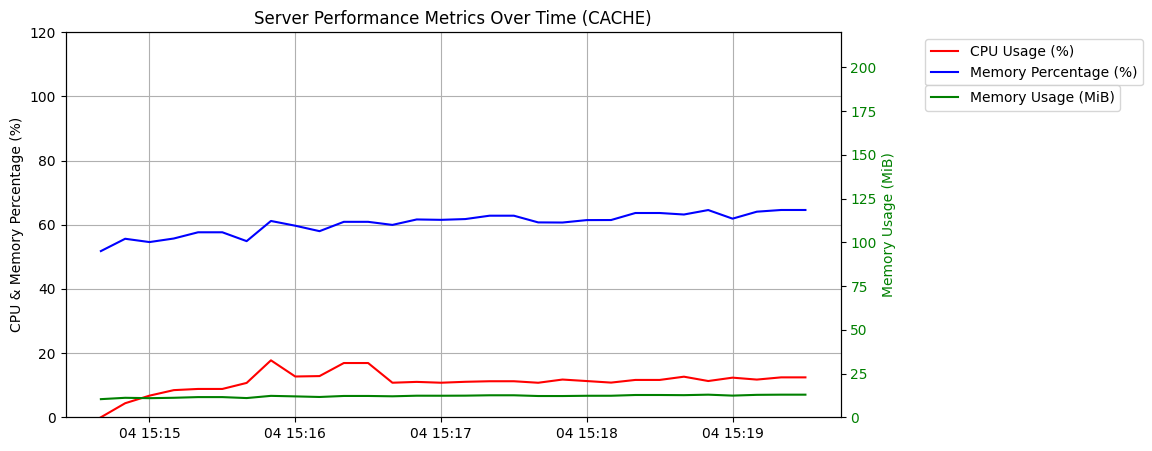

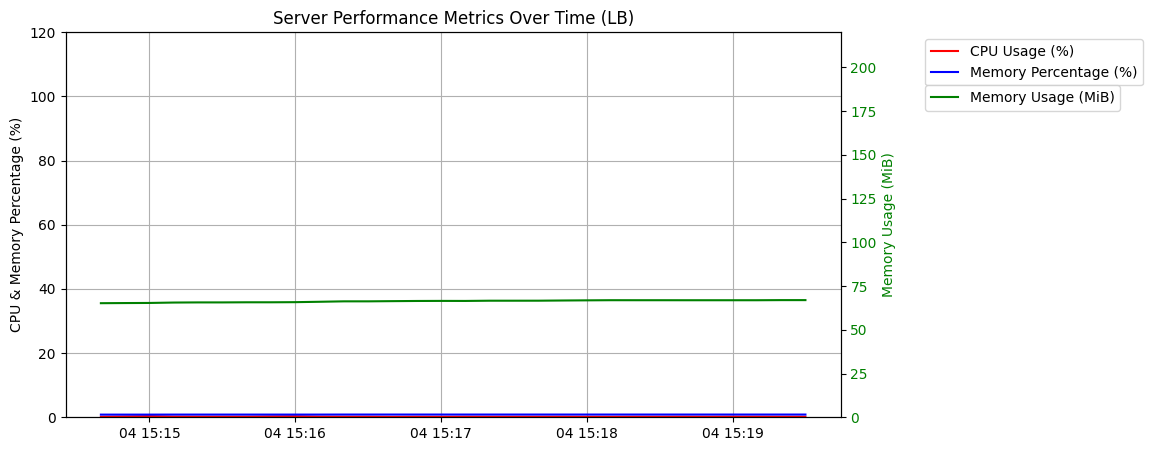

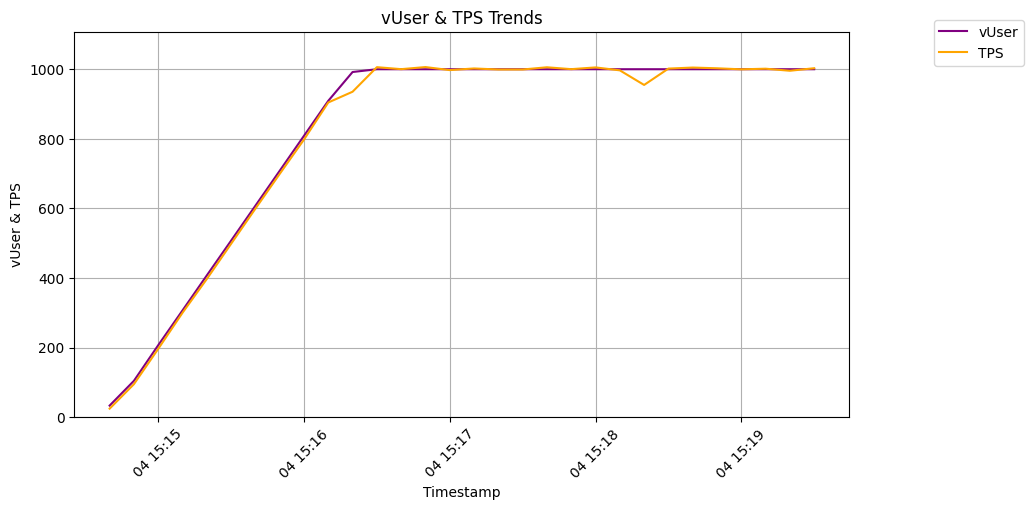

In [6]:
df = get_dataframe_from_csv(5)
display_chart(df)

# 여섯 번째 테스트

- **캐시 서버**
  - CPU: 1.05
  - Memory: 20M
- **api 서버**
  - CPU: 2.0
  - Memory: 100M
- **nGrinder**
  - Vusers: 1,000
  - Ramp-Up Interval: 1,000ms
- **Python**
  - N: 100,000
  - Func: `random.randint()` + `sum' + 'zip`
- **결과**
  - TPS: 225.6

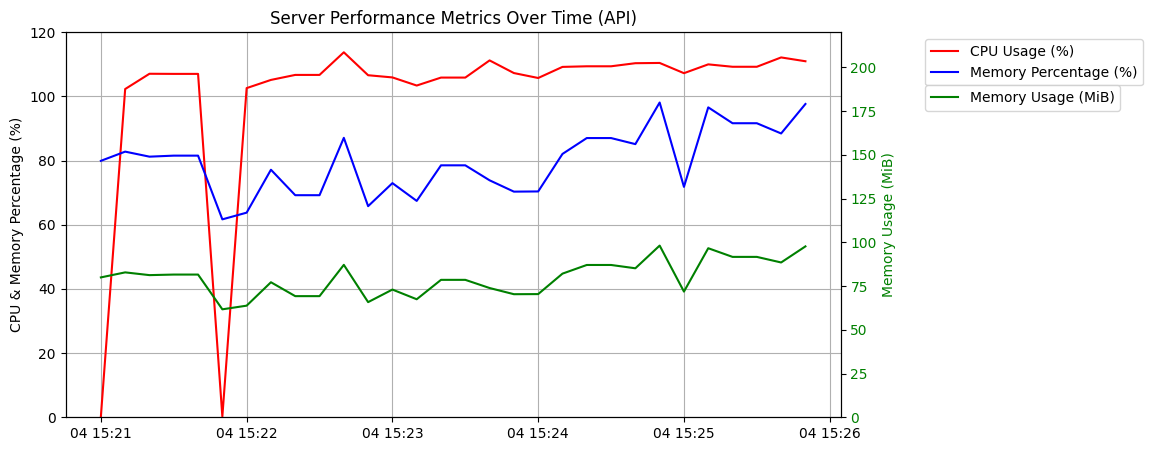

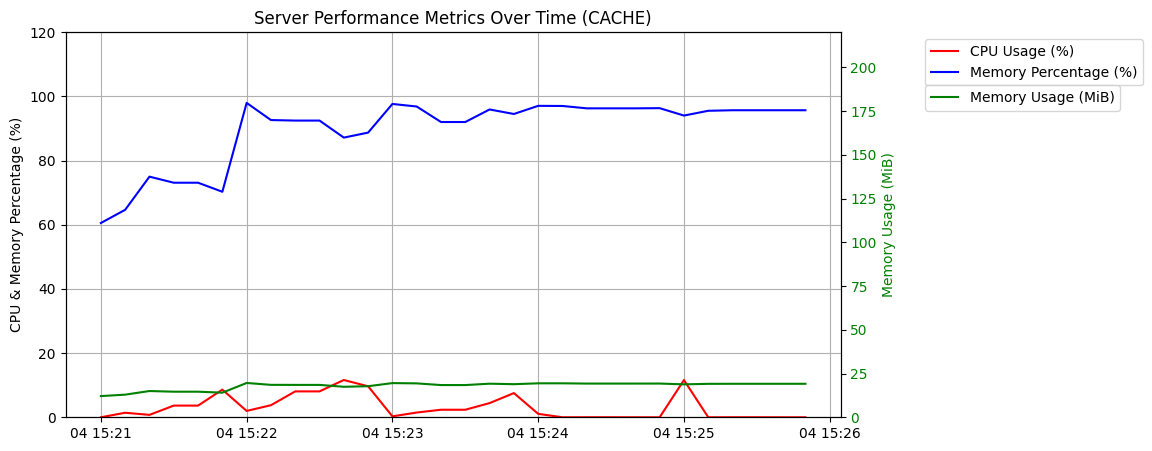

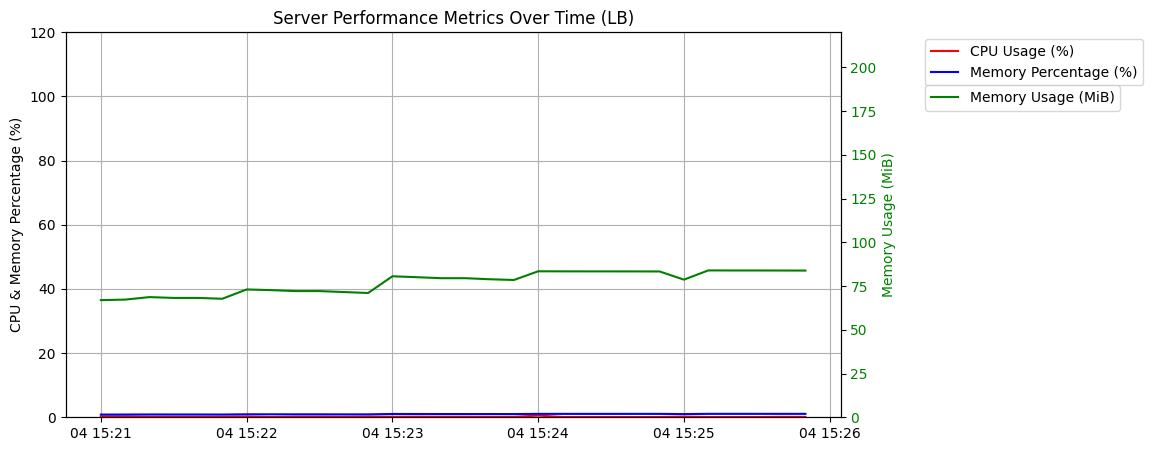

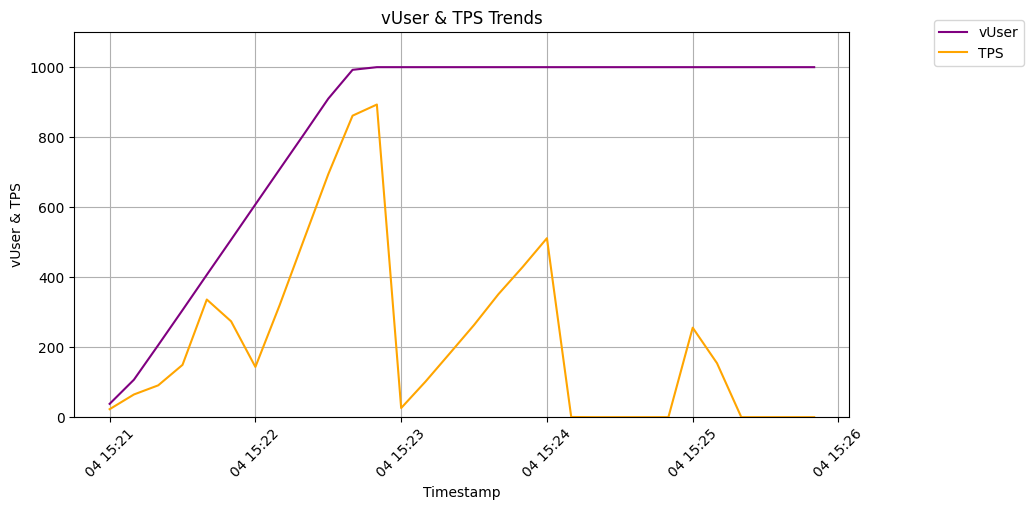

In [7]:
df = get_dataframe_from_csv(6)
display_chart(df)

# 일곱 번째 테스트

- **캐시 서버**
  - CPU: 1.05
  - Memory: 20M
- **api 서버**
  - CPU: 2.0
  - Memory: 500M
- **nGrinder**
  - Vusers: 1,000
  - Ramp-Up Interval: 1,000ms
- **Python**
  - N: 100,000
  - Func: `random.randint()` + `sum' + 'zip`
- **결과**
  - TPS: 273.7

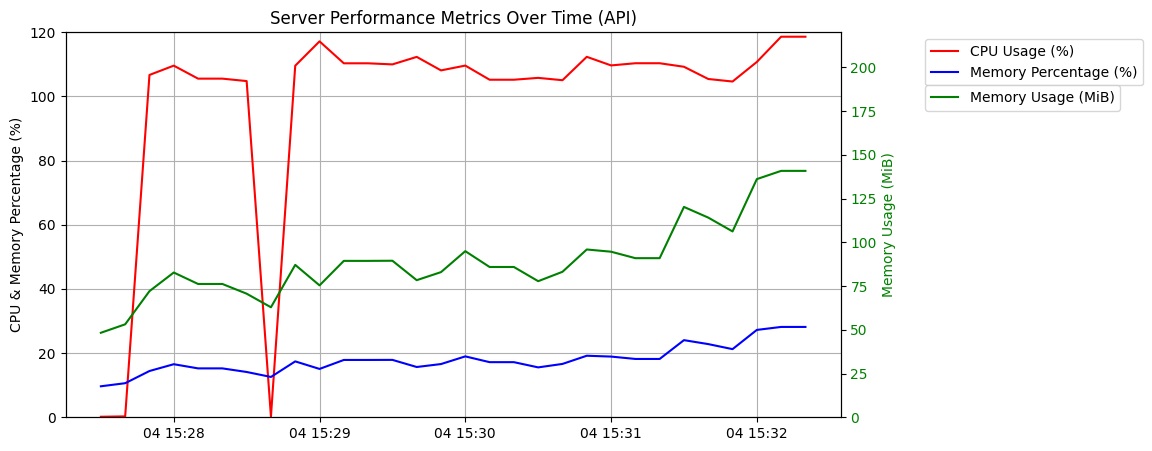

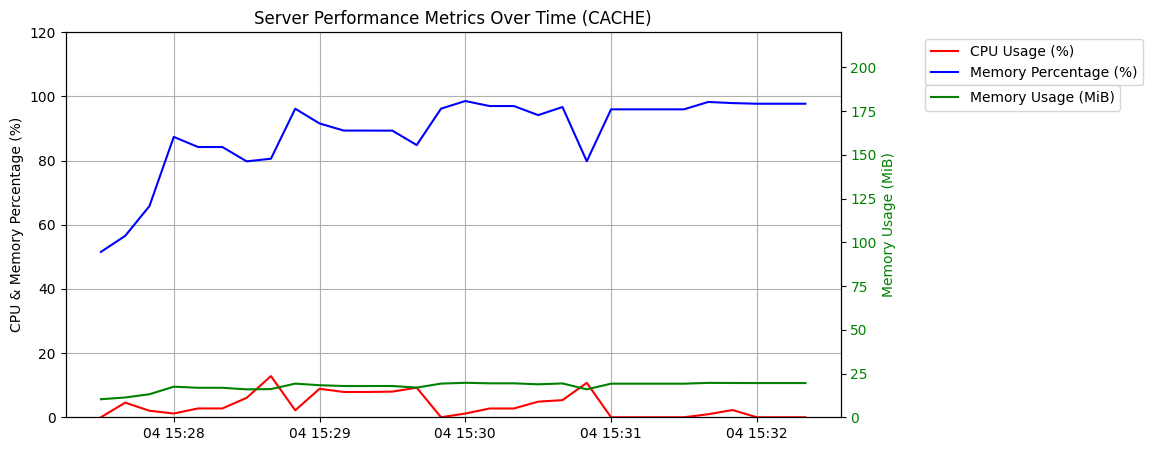

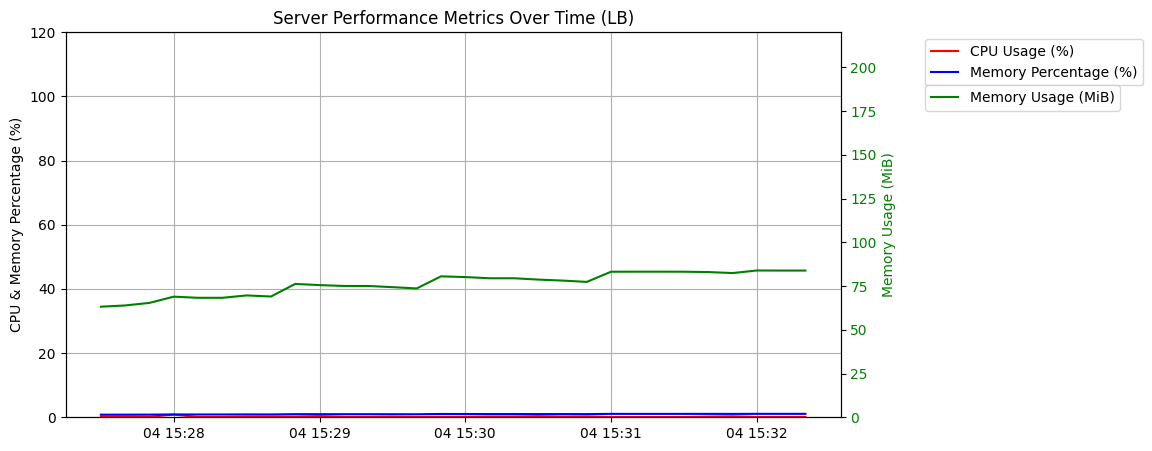

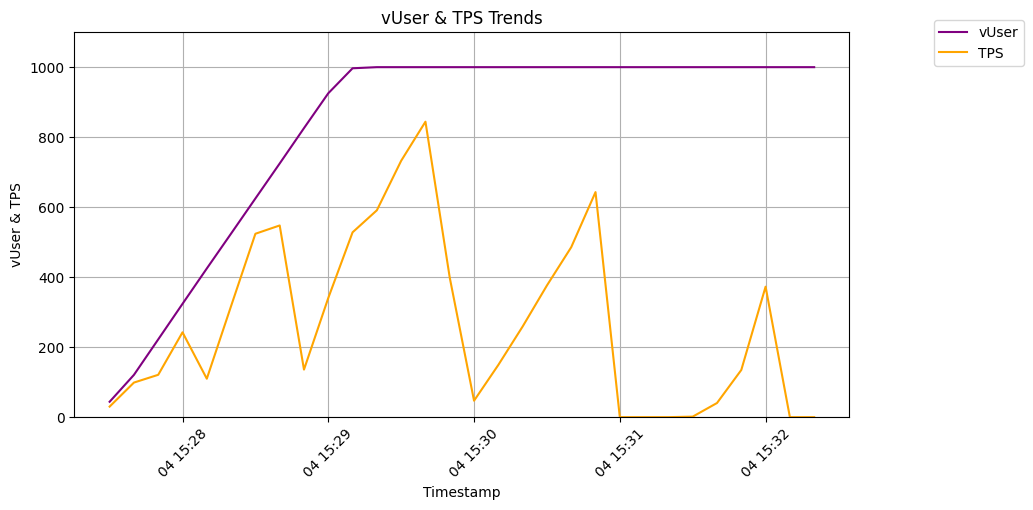

In [8]:
df = get_dataframe_from_csv(7)
display_chart(df)